In [87]:
import sarPrm as sp
import SARdata as Sd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as sc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage.interpolation import rotate
from PIL import Image


## Generate IGP image

[Text(0.5, 0, 'Eje x(m)'),
 Text(0, 0.5, 'Eje y(m)'),
 Text(0.5, 1.0, 'Imagen para la simulación')]

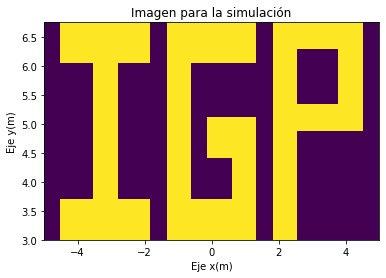

In [4]:
ro_x, ro_y = -5, 3 # Posicion inicial (x,y)m
d_x, d_y = 0.25,0.25#0.125,0.125 #0.25, 0.25 # Paso en los ejes (x,y)m
N_r, N_c = 16,41

# Formando las letras x separado
# Letra I
letraI = np.array([[1]*11]*3+[[0]*4+[1]*3+[0]*4]*10+[[1]*11]*3)
# Letra U
letraG = np.array([[1]*11]*3+[[1]*3+[0]*5+[1]*3]*3+[[1]*3+[0]*2+[1]*6]*3+[[1]*3+[0]*8]*4+[[1]*11]*3)
# Letra N
letraP = np.array([[[1]*3+[0]*8]*8 + [[1]*11]*2 + [[1]*3+[0]*5+[1]*3]*4 + [[1]*11]*2])

# Joining all the letters
Data = np.zeros((16,41))
Data[:,2:13] = letraI
Data[:,15:26] = letraG
Data[:,28:39] = letraP

I_t = Data.reshape(1,N_r*N_c)[0] # Vector de intensidades

rt_x=ro_x+d_x*np.arange(N_c) # Coordenada x de los targets(empezando en ro_x)
rt_y=ro_y+d_y*np.arange(N_r) # Coordenada y de los targets(empezando en ro_y)
rt=np.array([(x,y) for y in rt_y for x in rt_x]) #  Vector de coordenadas (x,y)

# Grafica de la imagen a simular
fig, ax = plt.subplots()
ax.imshow(Data,aspect='auto',origin='lower',extent=[rt_x.min(), rt_x.max(), rt_y.min(),rt_y.max()])
ax.set(xlabel='Eje x(m)',ylabel='Eje y(m)', title='Imagen para la simulación')



## Comparación de imágenes

In [72]:
def get_phaseH(prm, I_t, rt): # Parámetros, Vector de intensidades, vector de posiciones
    # Data
    c,fc,BW,Nf,Ls,Np = prm['c'],prm['fc'],prm['BW'],prm['Nf'],prm['Ls'],prm['Np']
    fi=fc-BW/2 # Frecuencia inferior(GHz)
    fs=fc+BW/2 # Frecuencia superior(GHz)

    Lista_f = np.linspace(fi, fs, Nf) #  Vector de frecuencias(GHz)
    Lista_pos = np.linspace(-Ls/2, Ls/2, Np) # Vector de posiciones del riel(m)

    """It2 = np.tile(I_t,[len(Lista_pos),len(Lista_f),1])
    rt2 = rt[:,0]+rt[:,1]*1j
    ff,pp,tt=np.meshgrid(Lista_f,Lista_pos,rt2)
    d = abs(pp-tt)
    k=2*np.pi*ff/c
    Sr_f2=It2*np.exp(-2j*k*d)
    Sr_f2=np.sum(Sr_f2,axis=2)"""

    #-------------------SCATTERED SIGNAL---------------------#

    Sr_f = np.array([sum(I_t[i]*np.exp(-1j*4*np.pi*fi*distance_nk(rt[i],xi)/c)
        for i in range(len(I_t))) for xi in Lista_pos for fi in Lista_f]) # Create a vector with value for each fi y ri
    Sr_f = np.reshape(Sr_f,(Np,Nf)) # Reshape the last vector Sr_f

    return Sr_f

def plotImage(data, x_min=None, x_max=None, y_min=None, y_max=None, xlabel_name=None, ylabel_name=None, title_name=None, unit_bar='', origin_n='lower', log=False, vmin=None,vmax=None,cmap="hot",orientation = "H",ticks=None):
    """
    Parameters
    ----------
    data : 2D-matrix
        Data a ser mostrado como figura
    x_min : float
        Valor mínimo del eje "x"
    x_max : float
        Valor máximo del eje "x"
    y_min : float
        Valor mínimo del eje "y"
    y_max : float
        Valor máximo del eje "y"

    Returns
    -------
    A message confirmation.
    """
    #np.savetxt("/home/diegopalma/Documents/github/roj_sar/GBSAR_Angle_Imaging_Algorithms/Simulation/arrays/RMA_1_data.txt", data)
    r_data = abs(data)
    if log: r_data = 20*np.log10(r_data)
    #if orientation == "H": nr,nc = 1,2 # Number of figure rows and columns
    #elif orientation == "V": nr,nc = 2,1

    if orientation == "H":
        fig, ax = plt.subplots(1,2,figsize=(12,6))#,sharex=True)
    elif orientation == "V":
        fig, ax = plt.subplots(2,1,figsize=(4,9))
    
    # Magnitude
    im1=ax[0].imshow(rotate(r_data, angle= 90, reshape= False),cmap=cmap,origin=origin_n,extent=[x_min, x_max, y_min, y_max], aspect='auto',vmin=vmin,vmax=vmax)
    ax[0].set(xlabel=xlabel_name, ylabel=ylabel_name, title="(Magnitud)") # Origin 'upper': esquina superior izquierda; 'lower': esquina inferior izquierda
    divider1 = make_axes_locatable(ax[0])
    cax1 = divider1.append_axes("right", size="5%", pad=0.1) # pad es el espaciado con la grafica principal
    sfmt=ticker.ScalarFormatter(useMathText=True)
    m=fig.colorbar(im1,cax=cax1,label=unit_bar,extend='both',ticks=ticks,format=sfmt)
    m.formatter.set_powerlimits((0, 0))
    m.ax.yaxis.set_offset_position('left')
    m.update_ticks()
    ax[0].grid(ls='--')

    # Phase
    im2=ax[1].imshow(np.angle(data), cmap, origin=origin_n, extent=[x_min, x_max, y_min, y_max], aspect='auto')#vmin=-600,vmax=-100)
    ax[1].set(xlabel=xlabel_name,ylabel=ylabel_name, title="(Fase)")
    divider2 = make_axes_locatable(ax[1])
    cax2 = divider2.append_axes("right", size="5%", pad=0.1) # pad es el espaciado con la grafica principal
    ax[1].grid(ls='--')
    
    plt.colorbar(im2,cax=cax2,label='(rad)',extend='both')
    fig.suptitle(title_name)
    if orientation == "H":
        fig.subplots_adjust(left=0.065, right=0.95, wspace=0.3)
        #fig.tight_layout() # cuadra bien las imagenes
        if title_name != None:
            fig.savefig("../figures/"+"RD1_2)"+"prueba_1",orientation='landscape')
    return 'Ok'
    
def plot_image_FDBP(data2):
    """ Grafica la magnitud de la imagen"""

    # a) Definicion y lectura de parametros
    Im = data2['Im']
    Lx = data2['Lx']
    Ly = data2['Ly']
    dx = data2['dx']
    dy = data2['dy']
    # b) Grafica final(magnitud)
    cmap="plasma"
    vmin = -100 #dB
    vmax = -20
    plotImage(Im,cmap=cmap,xlabel_name='Azimut(m)',ylabel_name='Rango(m)', title_name='Resultado Algoritmo Back Projection',
                 x_min=-(Lx+dx)/2, x_max=(Lx+dx)/2, y_min=0-dy/2, y_max=Ly+dy/2,unit_bar='(dB)',log=True,vmin=vmin,
                 vmax=vmax)

def plot_image_RMA(data2):
    """ Grafica la magnitud de la imagen"""
    # Save data
    np.save('../image_data/RMA_1_data.npy', data2)

    # a) Definicion y lectura de parametros
    Im = data2['Im'].copy()
    x = data2['x']
    y = data2['y']

    dx = x[1]-x[0]
    dy = y[1]-y[0]

    # c) Grafica final(magnitud)
    cmap="plasma"
    vmin = -100 #dB
    vmax = -20

    plotImage(Im,cmap=cmap,xlabel_name='Azimut(m)',ylabel_name='Rango(m)', title_name='Resultado Algoritmo Range Migration',
                 x_min=x[0]-dx/2, x_max=x[-1]+dx/2, y_min=y[0]-dy/2, y_max=y[-1]+dy/2,unit_bar='(dB)',log=True,vmin=vmin,
                 vmax=vmax)

prueba = "4"

def subplots_mag(data1, data2, data3):
    
    fig, ax = plt.subplots(1,3,figsize=(18,6))#,sharex=True)
    
    # Magnitude1
    ro_x, ro_y = -4, 0 # Posicion inicial (x,y)m
    d_x, d_y = 1.25*0.01,1.25*0.01 #0.125,0.125 #0.25, 0.25 # Paso en los ejes (x,y)m
    N_r, N_c = 801, 801
    rt_x=ro_x+d_x*np.arange(N_c) # Coordenada x de los targets(empezando en ro_x)
    rt_y=ro_y+d_y*np.arange(N_r) # Coordenada y de los targets(empezando en ro_y)
    rt=np.array([(x,y) for y in rt_y for x in rt_x]) #  Vector de coordenadas (x,y)
    ax[0].scatter(data1[0],data1[1], marker = 'o', linewidth = 2, color = 'r')
    ax[0].axis([-4, 4, 0, 8])
    ax[0].set(xlabel='Aximut(m)',ylabel='Rango(m)', title='Imagen para la simulación')
    ax[0].grid(ls='--')

    ## Magnitude2
    # a) Definicion y lectura de parametros
    Im = data2['Im']
    Lx = data2['Lx']
    Ly = data2['Ly']
    dx = data2['dx']
    dy = data2['dy']

    r_data2 = abs(Im)
    r_data2 = 20*np.log10(r_data2)


    xlabel_name='Azimut(m)'; ylabel_name='Rango(m)'; title_name='Resultado Algoritmo Back Projection'
    x_min=-(Lx+dx)/2; x_max=(Lx+dx)/2; y_min=0-dy/2; y_max=Ly+dy/2; unit_bar='(dB)'
    origin_n='lower'; ticks = None
    cmap="plasma"
    vmin = -100 #dB
    vmax = -20

    im2 =ax[1].imshow(r_data2,cmap=cmap,origin=origin_n,extent=[x_min, x_max, y_min, y_max], aspect='auto',vmin=vmin,vmax=vmax)
    ax[1].set(xlabel=xlabel_name, ylabel=ylabel_name, title="Resultado Algoritmo Back Projection") # Origin 'upper': esquina superior izquierda; 'lower': esquina inferior izquierda
    divider1 = make_axes_locatable(ax[1])
    cax1 = divider1.append_axes("right", size="5%", pad=0.1) # pad es el espaciado con la grafica principal
    sfmt=ticker.ScalarFormatter(useMathText=True)
    m=fig.colorbar(im2,cax=cax1,label=unit_bar,extend='both',ticks=ticks,format=sfmt)
    m.formatter.set_powerlimits((0, 0))
    m.ax.yaxis.set_offset_position('left')
    m.update_ticks()
    ax[1].grid(ls='--')

    ## Magnitude3

    # a) Definicion y lectura de parametros
    Im = data3['Im'].copy()
    x = data3['x']
    y = data3['y']
    r_data3 = abs(Im)
    r_data3 = 20*np.log10(r_data3)

    dx = x[1]-x[0]
    dy = y[1]-y[0]

    xlabel_name='Azimut(m)'; ylabel_name='Rango(m)'; title_name='Resultado Algoritmo Range Migration'
    x_min=x[0]-dx/2; x_max=x[-1]+dx/2; y_min=y[0]-dy/2; y_max=y[-1]+dy/2; unit_bar='(dB)'
    origin_n='lower'; ticks = None
    cmap="plasma"
    vmin = -100 #dB
    vmax = -20

    im3=ax[2].imshow(r_data3,cmap=cmap,origin=origin_n,extent=[x_min, x_max, y_min, y_max], aspect='auto',vmin=vmin,vmax=vmax)
    ax[2].set(xlabel=xlabel_name, ylabel=ylabel_name, title="Resultado Algoritmo Range Migration") # Origin 'upper': esquina superior izquierda; 'lower': esquina inferior izquierda
    divider1 = make_axes_locatable(ax[2])
    cax1 = divider1.append_axes("right", size="5%", pad=0.1) # pad es el espaciado con la grafica principal
    sfmt=ticker.ScalarFormatter(useMathText=True)
    m=fig.colorbar(im3,cax=cax1,label=unit_bar,extend='both',ticks=ticks,format=sfmt)
    m.formatter.set_powerlimits((0, 0))
    m.ax.yaxis.set_offset_position('left')
    m.update_ticks()
    ax[2].grid(ls='--')

    fig.suptitle("Gráficas de Magnitud")

    fig.subplots_adjust(left=0.065, right=0.95, wspace=0.3)
    #fig.tight_layout() # cuadra bien las imagenes
    fig.savefig("../figures/"+"RD1_2)"+"prueba_"+prueba+"_mag",orientation='landscape')

    return 'Ok'

def subplots_phase(data2, data3):

    fig, ax = plt.subplots(1,3,figsize=(18,6))#,sharex=True)

    # Phase 2
    # a) Definicion y lectura de parametros
    Im = data2['Im']
    Lx = data2['Lx']
    Ly = data2['Ly']
    dx = data2['dx']
    dy = data2['dy']

    xlabel_name='Azimut(m)'; ylabel_name='Rango(m)'; title_name='Resultado Algoritmo Back Projection'
    x_min=-(Lx+dx)/2; x_max=(Lx+dx)/2; y_min=0-dy/2; y_max=Ly+dy/2; unit_bar='(rad)'
    origin_n='lower'; ticks = None
    cmap="plasma"

    im2=ax[1].imshow(np.angle(Im), cmap, origin=origin_n, extent=[x_min, x_max, y_min, y_max], aspect='auto')#vmin=-600,vmax=-100)
    ax[1].set(xlabel=xlabel_name,ylabel=ylabel_name, title="Resultado Algoritmo Back Projection")
    divider2 = make_axes_locatable(ax[1])
    cax2 = divider2.append_axes("right", size="5%", pad=0.1) # pad es el espaciado con la grafica principal
    sfmt=ticker.ScalarFormatter(useMathText=True)
    m=fig.colorbar(im2,cax=cax2,label=unit_bar,extend='both',ticks=ticks,format=sfmt)
    m.formatter.set_powerlimits((0, 0))
    m.ax.yaxis.set_offset_position('left')
    m.update_ticks()
    ax[1].grid(ls='--')

    # Phase 1
    im1=ax[0].imshow(np.zeros([801,801]), cmap, origin=origin_n, extent=[x_min, x_max, y_min, y_max], aspect='auto')#vmin=-600,vmax=-100)
    ax[0].set(xlabel=xlabel_name,ylabel=ylabel_name, title="Fase Original")
    divider2 = make_axes_locatable(ax[0])
    cax2 = divider2.append_axes("right", size="5%", pad=0.1) # pad es el espaciado con la grafica principal
    sfmt=ticker.ScalarFormatter(useMathText=True)
    m=fig.colorbar(im1,cax=cax2,label=unit_bar,extend='both',ticks=ticks,format=sfmt)
    m.formatter.set_powerlimits((0, 0))
    m.ax.yaxis.set_offset_position('left')
    m.update_ticks()
    ax[0].grid(ls='--')

    ## Phase 3

    # a) Definicion y lectura de parametros
    Im = data3['Im'].copy()
    x = data3['x']
    y = data3['y']

    dx = x[1]-x[0]
    dy = y[1]-y[0]

    xlabel_name='Azimut(m)'; ylabel_name='Rango(m)'; title_name='Resultado Algoritmo Range Migration'
    x_min=x[0]-dx/2; x_max=x[-1]+dx/2; y_min=y[0]-dy/2; y_max=y[-1]+dy/2; unit_bar='(rad)'
    origin_n='lower'; ticks = None
    cmap="plasma"

    im3=ax[2].imshow(np.angle(Im), cmap, origin=origin_n, extent=[x_min, x_max, y_min, y_max], aspect='auto')#vmin=-600,vmax=-100)
    ax[2].set(xlabel=xlabel_name,ylabel=ylabel_name, title="Resultado Algoritmo Range Migration")
    divider2 = make_axes_locatable(ax[2])
    cax2 = divider2.append_axes("right", size="5%", pad=0.1) # pad es el espaciado con la grafica principal
    sfmt=ticker.ScalarFormatter(useMathText=True)
    m=fig.colorbar(im3,cax=cax2,label=unit_bar,extend='both',ticks=ticks,format=sfmt)
    m.formatter.set_powerlimits((0, 0))
    m.ax.yaxis.set_offset_position('left')
    m.update_ticks()
    ax[2].grid(ls='--')

    fig.suptitle("Gráficas de Phase")
    fig.subplots_adjust(left=0.065, right=0.95, wspace=0.3)
    #fig.tight_layout() # cuadra bien las imagenes
    fig.savefig("../figures/"+"RD1_2)"+"prueba_"+prueba+"_phase",orientation='landscape')

    return 'Ok!'


In [73]:
prueba = "2"
data_fdbp = np.load('../image_data/FDBP_'+prueba+'_data.npy', allow_pickle='TRUE').item()
data_rma = np.load('../image_data/RMA_'+prueba+'_data.npy', allow_pickle='TRUE').item()

'Ok'

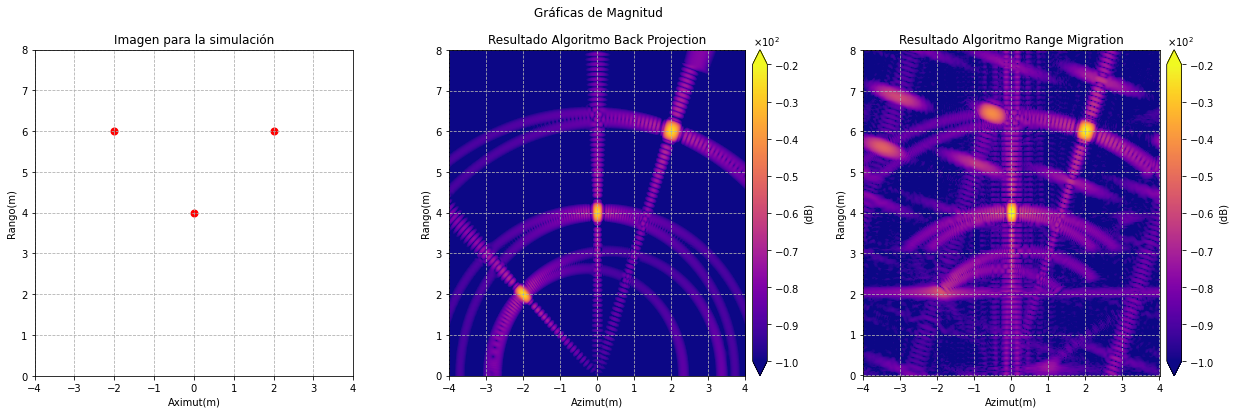

In [74]:
data1 = np.array([[-2, 0, 2], [6, 4 ,6]])
# Grafica de la imagen a simular
subplots_mag(data1, data_fdbp, data_rma)


'Ok!'

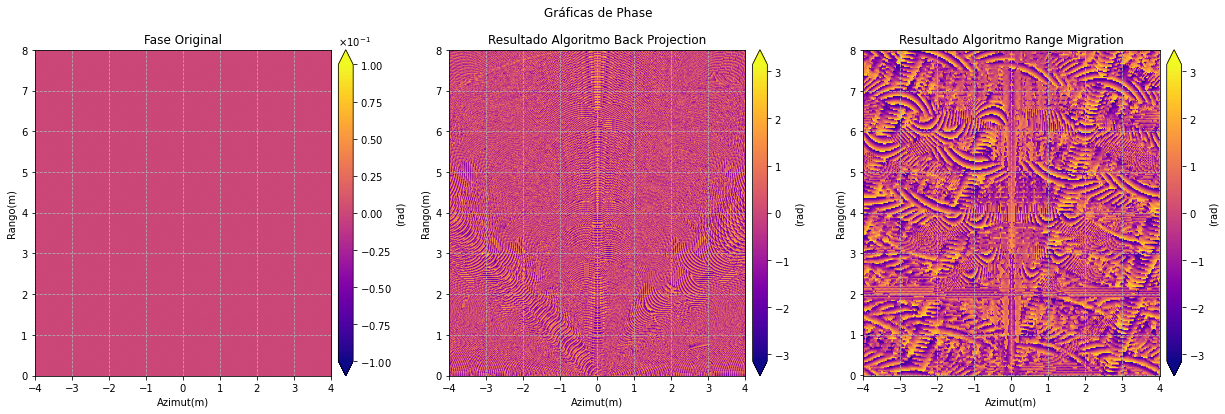

In [75]:
data1 = np.array([[-2, 0, 2], [6, 4 ,6]])
# Grafica de la imagen a simular
subplots_phase(data_fdbp, data_rma)

## Squint mode angle

In [76]:
prueba = "9"
data_squint_fdbp = np.load('../image_data/FDBP_'+prueba+'_data.npy', allow_pickle='TRUE').item()

In [81]:
x= np.array([[1,2,3], [2,0, 4], [5,6,7]])
col= 2
y = np.pad(x, [[col, col], [col, col]], 'constant', constant_values=0)
y

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 2, 3, 0, 0],
       [0, 0, 2, 0, 4, 0, 0],
       [0, 0, 5, 6, 7, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

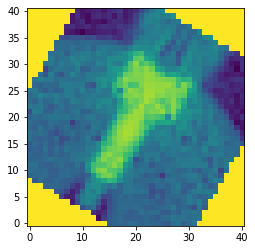

In [100]:
im = np.load('../image_data/FDBP_'+"9"+'_data.npy', allow_pickle='TRUE').item()
im = 20*np.log(abs(im["Im"]))
plt.imshow(rotate(im, angle= 30, reshape = False), origin = "lower")
#rotate(x, angle = 30)

In [85]:
rotate(x, angle = 30, reshape = False)

array([[0, 3, 0],
       [1, 0, 6],
       [0, 5, 0]])

In [83]:
help(rotate)

Help on function rotate in module scipy.ndimage.interpolation:

rotate(input, angle, axes=(1, 0), reshape=True, output=None, order=3, mode='constant', cval=0.0, prefilter=True)
    Rotate an array.
    
    The array is rotated in the plane defined by the two axes given by the
    `axes` parameter using spline interpolation of the requested order.
    
    Parameters
    ----------
    input : array_like
        The input array.
    angle : float
        The rotation angle in degrees.
    axes : tuple of 2 ints, optional
        The two axes that define the plane of rotation. Default is the first
        two axes.
    reshape : bool, optional
        If `reshape` is true, the output shape is adapted so that the input
        array is contained completely in the output. Default is True.
    output : array or dtype, optional
        The array in which to place the output, or the dtype of the
        returned array. By default an array of the same dtype as input
        will be created.
 

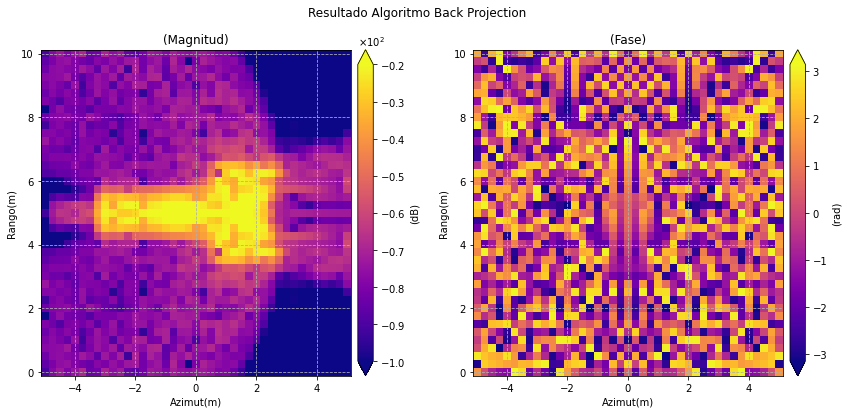

In [77]:
plot_image_FDBP(data_squint_fdbp)

In [30]:
temp = data_squint_fdbp["Im"]
temp2 = np.zeros(temp.shape)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [45]:
x = np.linspace(0,40,41)
y = np.linspace(0,40,41)
y, x= np.meshgrid(x,y)

m= rotate(y, angle = 90, reshape = False)

In [46]:
m

array([[4.00000000e+01, 4.00000000e+01, 4.00000000e+01, ...,
        4.00000000e+01, 4.00000000e+01, 4.00000000e+01],
       [3.90000000e+01, 3.90000000e+01, 3.90000000e+01, ...,
        3.90000000e+01, 3.90000000e+01, 3.90000000e+01],
       [3.80000000e+01, 3.80000000e+01, 3.80000000e+01, ...,
        3.80000000e+01, 3.80000000e+01, 3.80000000e+01],
       ...,
       [2.00000000e+00, 2.00000000e+00, 2.00000000e+00, ...,
        2.00000000e+00, 2.00000000e+00, 2.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.65958193e-16, 1.65958193e-16, 1.93713769e-16, ...,
        2.21469344e-16, 2.76980496e-16, 2.21469344e-16]])

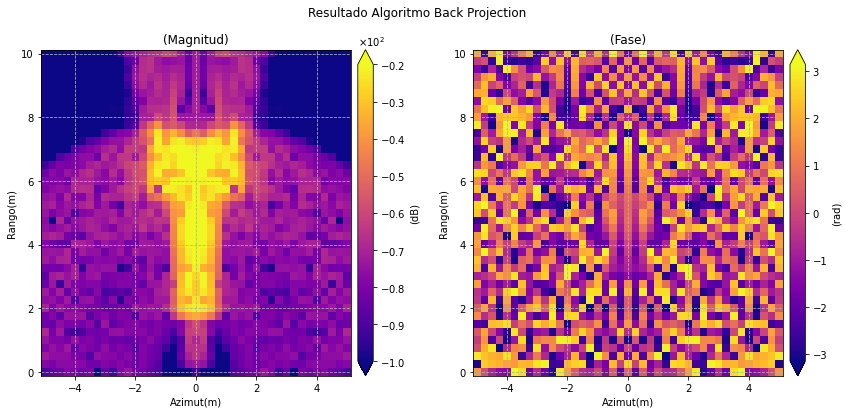

In [11]:
plot_image_FDBP(data_squint_fdbp)